<a href="https://colab.research.google.com/github/PauloBochnia/bootcamp_projeto4/blob/main/Projeto_4_Paulo_Bochnia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação

Notebook do Paulo Vinicius N. Bochnia

Linkedin: https://www.linkedin.com/in/paulobochnia/

Administrador, Pós Graduando em Big Data/ Inteligência Artificial e Business Intelligence.

Analista de Business Intelligence e aspirante a Data Scientist.

# Resumo

Neste trabalho resolvi analisar os dados provenientes de SRAG - Sindrome Respiratória Aguda Grave - que tivemos do ano de 2020 até o momento (Janeiro de 2021). Além de limpar os dados, e mostrar o tratamento, também analiso algumas hipóteses de relação entre o banco de dados, para depois, prever os números que ainda serão mostrados para os próximos meses.

## Um pouco da SRAG

O Ministério da Saúde (MS), por meio da Secretaria de Vigilância em Saúde (SVS), desenvolve a vigilância da Síndrome Respiratória Aguda Grave (SRAG) no Brasil, desde a pandemia de Influenza A(H1N1)pdm09 em 2009. A partir disso, esta vigilância foi implantada na rede de Influenza e outros vírus respiratórios, que anteriormente atuava apenas com a vigilância sentinela de Síndrome Gripal (SG).

Recentemente (2020), a vigilância da COVID-19, a infecção humana causada pelo novo Coronavírus, foi incorporada na rede de vigilância da Influenza e outros vírus respiratórios.

# Análise dos Dados

Para analisarmos os nossos dados, o estudo é divido em 5 partes, que são: Importação dos dados; Análise de Dados; Predição de Resultados; e Conclusão. 

## 1. Importação dos Dados

Capitulo de ETL (extract, transform and load) para organizar os DataFrames que utilizaremos ao longo do estudo. Os bancos de dados são:

• 	Dados de SRAG 2020. fonte - https://opendatasus.saude.gov.br/dataset/bd-srag-2020.

### 1.1 Importando Bibliotecas

In [ ]:
import pandas as pd
import copy
import numpy as np
import datetime
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.widgets as widgets
import seaborn as sns
import missingno as msno
from statsmodels.stats.weightstats import ztest
from scipy.stats import normaltest
from scipy.stats import ranksums
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ModuleNotFoundError: ignored

### 1.2 Importação e Transformação dos Dados

Importação/Tratamento dos bancos e denominação das variáveis.

In [ ]:
#Selecionar somente as colunas que serão selecionadas para a análise da base
rename_lista = {'DT_SIN_PRI': 'data_primeiro_sintoma',
               'SEM_PRI': 'semana_epid_primeiro_sintoma',
               'CS_SEXO': 'sexo',
               'NU_IDADE_N': 'idade',
               'CS_GESTANT': 'gestante',
               'CS_RACA': 'raça',
               'CS_ESCOL_N': 'escolaridade',
               'SG_UF': 'uf_paciente',
               'ID_MN_RESI': 'municipio_paciente',
               'CO_MUN_RES': 'municipio_paciente2',
               'ID_PAIS': 'pais_paciente',
               'NOSOCOMIAL': 'infeccao_adquirida_hospital',
               'SG_UF_INTE': 'estado_internacao',
               'ID_RG_INTE': 'municipio_internacao',
               'CO_RG_INTE': 'municipio_internacao2',
                'UTI': 'internado_uti',
                'SUPORT_VEN': 'usou_suporte_ventilatório',
                'CLASSI_FIN': 'classificacao_final_resultado',
                'EVOLUCAO': 'evolucao_caso',
                'DT_EVOLUCA': 'data_evolucao',
                'DT_INTERNA': 'data_internacao',
                'HOSPITAL': 'teve_internacao',
                'FATOR_RISC': 'fator_risco'
               }
colunas_para_pegar = ['DT_SIN_PRI',
                       'SEM_PRI',
                       'CS_SEXO',
                       'NU_IDADE_N',
                       'CS_GESTANT',
                       'CS_RACA',
                       'CS_ESCOL_N',
                       'SG_UF',
                       'ID_MN_RESI',
                       'CO_MUN_RES',
                       'ID_PAIS',
                       'NOSOCOMIAL',
                       'SG_UF_INTE',
                       'ID_RG_INTE',
                       'CO_RG_INTE',
                        'UTI',
                        'SUPORT_VEN',
                        'CLASSI_FIN',
                        'EVOLUCAO',
                        'DT_EVOLUCA',
                        'DT_INTERNA',
                        'HOSPITAL',
                        'FATOR_RISC']

             

In [ ]:
#Extraindo os dados de Covid
dados_srag_chunk = pd.read_csv('https://github.com/PauloBochnia/bootcamp_projeto4/blob/b530b7921490490d2ed4495cc4135eecfed65029/INFLUD-18-01-2021.zip?raw=true'
                   , encoding = 'ISO-8859-1', sep =';', decimal =',',chunksize= 100000, usecols=colunas_para_pegar, compression='zip')

In [ ]:
dados_srag = pd.DataFrame()
for chunk in dados_srag_chunk:
    chunk.fillna('NaN',inplace = True)
    df_extrator = pd.DataFrame(chunk)
    df_extrator = df_extrator.reset_index()
    dados_srag = pd.concat([dados_srag,df_extrator],ignore_index=True)

In [ ]:
#contruindo dicionários
dic_CS_SEXO = {'M': 'masculino',
           'F': 'feminino',
           'I': 'ignorado'}

dic_CS_GESTANT = {1: '1º Trimestre',
               2: '2º Trimestre',
               3: '3º Trimestre',
               4: 'Idade Gestacional Ignorada',
               5: 'Não',
               6: 'Não se aplica',
               9: 'Ignorado',
                 0: np.nan}

dic_CS_RACA = {1: 'Branca',
               2: 'Preta',
               3: 'Amarela',
               4: 'Parda',
               5: 'Indígena',
               9: 'Ignorado',
               'NaN': np.nan}

dic_CS_ESCOL_N = {0: 'Sem escolaridade/Analfabeto',
                  1: 'Fundamental 1º ciclo (1ª a 5ª série)',
                  2: 'Fundamental 2º ciclo (6ª a 9ª série)',
                  3: ' Médio (1º ao 3º ano)',
                  4: 'Superior',
                  5: 'Não se aplica',
                  9: 'Ignorado',
                  'NaN': np.nan}

dic_NOSOCOMIAL = {1: 'Sim',
                  2: 'Não',
                  9: 'Ignorado',
                  'NaN': np.nan}

dic_HOSPITAL = {1: 'Sim',
                2: 'Não',
                9: 'Ignorado',
                'NaN': np.nan}

dic_UTI = {1: 'Sim',
           2: 'Não',
           9: 'Ignorado',
           'NaN': np.nan}

dic_SUPORT_VEN = {1: 'Sim, invasivo',
                  2: 'Sim, não invasivo',
                  3: 'Não',
                  9: 'Ignorado',
                  'NaN': np.nan}

dic_CLASSI_FIN = {1.0: 'SRAG por influenza',
                  2.0: 'SRAG por outro vírus respiratório',
                  3.0: 'SRAG por outro agente etiológico, qual:',
                  4.0: 'SRAG não especificado',
                  5.0: 'SRAG por COVID-19',
                  'NaN': np.nan}

dic_EVOLUCAO = {1.0: 'Cura',
                2.0: 'Óbito',
                3.0: 'Óbito por outras causas',
                9.0: 'Ignorado',
               'NaN': np.nan}

dic_FATOR_RISC = {'S': 'Sim',
           'N': 'Não',
           9: 'Ignorado',
           'NaN': np.nan}

In [ ]:
def formatar_respostas(value):
    dados_srag[value] = dados_srag[value].map(lambda x:eval(f'dic_{value}')[x])
    
def formatar_vazios(column):
    dados_srag[column].replace('NaN',np.nan,inplace=True)

In [ ]:
formatar_respostas('CS_SEXO')
formatar_respostas('CS_GESTANT')
formatar_respostas('CS_RACA')
formatar_respostas('CS_ESCOL_N')
formatar_respostas('NOSOCOMIAL')
formatar_respostas('HOSPITAL')
formatar_respostas('UTI')
formatar_respostas('SUPORT_VEN')
formatar_respostas('CLASSI_FIN')
formatar_respostas('EVOLUCAO')
formatar_respostas('FATOR_RISC')

formatar_vazios('DT_SIN_PRI')
formatar_vazios('SEM_PRI')
formatar_vazios('NU_IDADE_N')
formatar_vazios('ID_PAIS')
formatar_vazios('SG_UF')
formatar_vazios('ID_MN_RESI')
formatar_vazios('CO_MUN_RES')
formatar_vazios('NOSOCOMIAL')
formatar_vazios('HOSPITAL')
formatar_vazios('DT_INTERNA')
formatar_vazios('SG_UF_INTE')
formatar_vazios('ID_RG_INTE')
formatar_vazios('CO_RG_INTE')
formatar_vazios('UTI')
formatar_vazios('SUPORT_VEN')
formatar_vazios('CLASSI_FIN')
formatar_vazios('EVOLUCAO')
formatar_vazios('DT_EVOLUCA')


In [ ]:
dados_srag.drop('index', axis=1, inplace=True)

In [ ]:
dados_srag.rename(rename_lista, axis=1, inplace=True)

In [ ]:
dados_srag['data_primeiro_sintoma'] = pd.to_datetime(dados_srag['data_primeiro_sintoma'])
dados_srag['data_internacao'] = pd.to_datetime(dados_srag['data_internacao'], errors='coerce')
dados_srag['data_evolucao'] = pd.to_datetime(dados_srag['data_evolucao'])

In [ ]:
dados_srag.isna().sum()

data_primeiro_sintoma                 0
semana_epid_primeiro_sintoma          0
sexo                                  0
idade                                 0
gestante                            260
raça                              56123
escolaridade                     349707
pais_paciente                         0
uf_paciente                         112
municipio_paciente                  112
municipio_paciente2                 112
infeccao_adquirida_hospital      245497
fator_risco                           0
teve_internacao                   31716
data_internacao                   94006
estado_internacao                    14
municipio_internacao             275741
municipio_internacao2            275741
internado_uti                    167318
usou_suporte_ventilatório        158558
classificacao_final_resultado    105871
evolucao_caso                    200780
data_evolucao                    284385
dtype: int64

<AxesSubplot:>

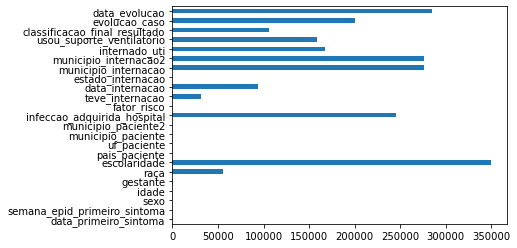

In [ ]:
dados_srag.isna().sum().plot(kind='barh')

In [ ]:
def criar_comparativo_de_dados_faltantes(value):

    dados_faltantes_total = pd.DataFrame(dados_srag.isna().sum(), columns= ['faltantes_total'])
    dados_faltantes_total_sem_data_evolucao = pd.DataFrame(dados_srag[dados_srag[value].isna()].isna().sum(), columns= [value])
    comparacao = pd.merge(dados_faltantes_total,dados_faltantes_total_sem_data_evolucao,left_index = True, right_index = True)[['faltantes_total',value]]

    comparacao['%repres'] = comparacao[value]/comparacao['faltantes_total']
    display(comparacao)
    plt.figure(figsize=(14,6))
    plt.title(f'% de Representatividade dos dados faltantes de {value} sobre Total', fontsize=20)
    plt.xlabel('% de Representatividade', fontsize=20)
    plt.ylabel('Colunas', fontsize=20)
    grafico = comparacao['%repres'].plot(kind='barh')
    grafico
    grafico.xaxis.set_major_formatter(ticker.PercentFormatter())

,faltantes_total,data_evolucao,%repres
data_primeiro_sintoma,0,0,NaN
semana_epid_primeiro_sintoma,0,0,NaN
sexo,0,0,NaN
idade,0,0,NaN
gestante,260,127,0.488462
raça,56123,13127,0.233897
escolaridade,349707,98528,0.281744
pais_paciente,0,0,NaN
uf_paciente,112,30,0.267857
municipio_paciente,112,30,0.267857


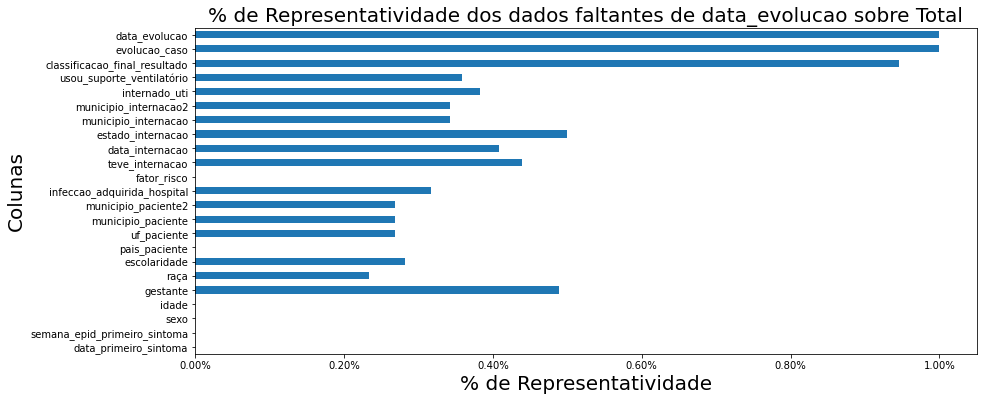

In [ ]:
criar_comparativo_de_dados_faltantes('data_evolucao')

,faltantes_total,teve_internacao,%repres
data_primeiro_sintoma,0,0,NaN
semana_epid_primeiro_sintoma,0,0,NaN
sexo,0,0,NaN
idade,0,0,NaN
gestante,260,13,0.050000
raça,56123,3404,0.060652
escolaridade,349707,18954,0.054200
pais_paciente,0,0,NaN
uf_paciente,112,5,0.044643
municipio_paciente,112,5,0.044643


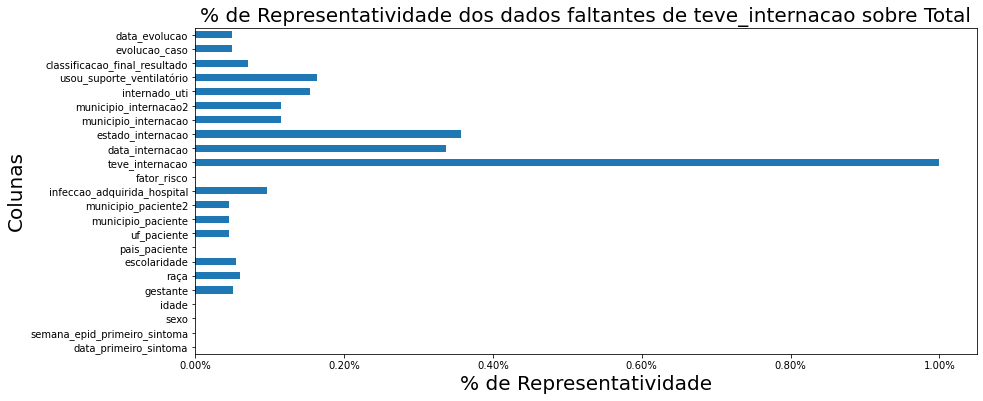

In [ ]:
criar_comparativo_de_dados_faltantes('teve_internacao')

,faltantes_total,municipio_internacao,%repres
data_primeiro_sintoma,0,0,NaN
semana_epid_primeiro_sintoma,0,0,NaN
sexo,0,0,NaN
idade,0,0,NaN
gestante,260,131,0.503846
raça,56123,17395,0.309944
escolaridade,349707,91522,0.261711
pais_paciente,0,0,NaN
uf_paciente,112,30,0.267857
municipio_paciente,112,30,0.267857


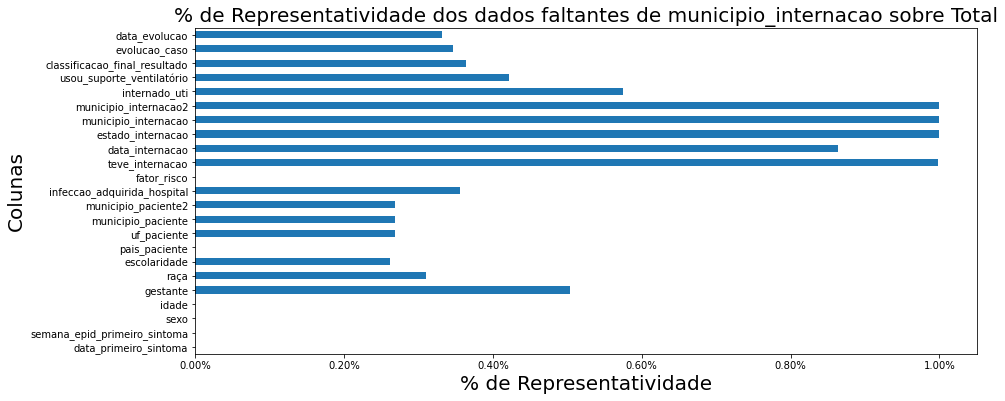

In [ ]:
criar_comparativo_de_dados_faltantes('municipio_internacao')

,faltantes_total,internado_uti,%repres
data_primeiro_sintoma,0,0,NaN
semana_epid_primeiro_sintoma,0,0,NaN
sexo,0,0,NaN
idade,0,0,NaN
gestante,260,115,0.442308
raça,56123,15332,0.273186
escolaridade,349707,86996,0.248768
pais_paciente,0,0,NaN
uf_paciente,112,18,0.160714
municipio_paciente,112,18,0.160714


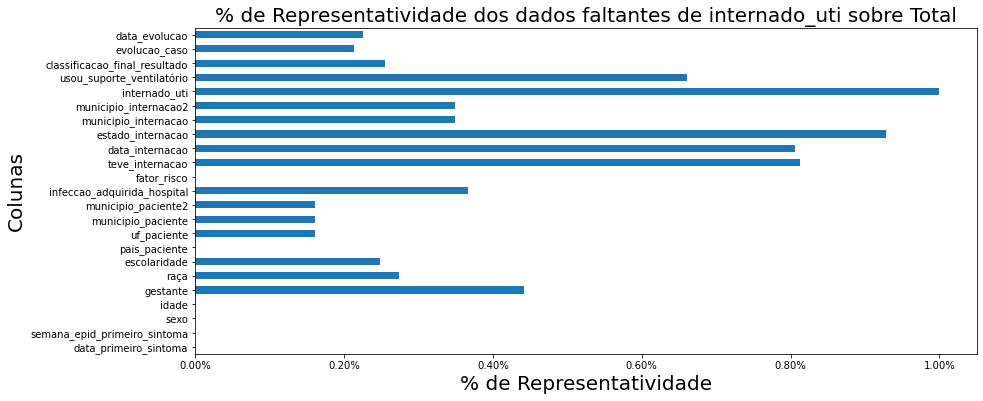

In [ ]:
criar_comparativo_de_dados_faltantes('internado_uti')

In [ ]:
index_de_dados_faltantes = []
analise = dados_srag[dados_srag['internado_uti'].isna()].index
for x in analise:
    index_de_dados_faltantes.append(x)
analise = dados_srag[dados_srag['municipio_internacao'].isna()].index
for x in analise:
    index_de_dados_faltantes.append(x)
analise = dados_srag[dados_srag['teve_internacao'].isna()].index
for x in analise:
    index_de_dados_faltantes.append(x)
analise = dados_srag[dados_srag['data_evolucao'].isna()].index
for x in analise:
    index_de_dados_faltantes.append(x)

,faltantes_total,Colunas de análise,%repres
data_primeiro_sintoma,0,0,NaN
semana_epid_primeiro_sintoma,0,0,NaN
sexo,0,0,NaN
idade,0,0,NaN
gestante,260,178,0.684615
raça,56123,29232,0.520856
escolaridade,349707,184342,0.527133
pais_paciente,0,0,NaN
uf_paciente,112,48,0.428571
municipio_paciente,112,48,0.428571


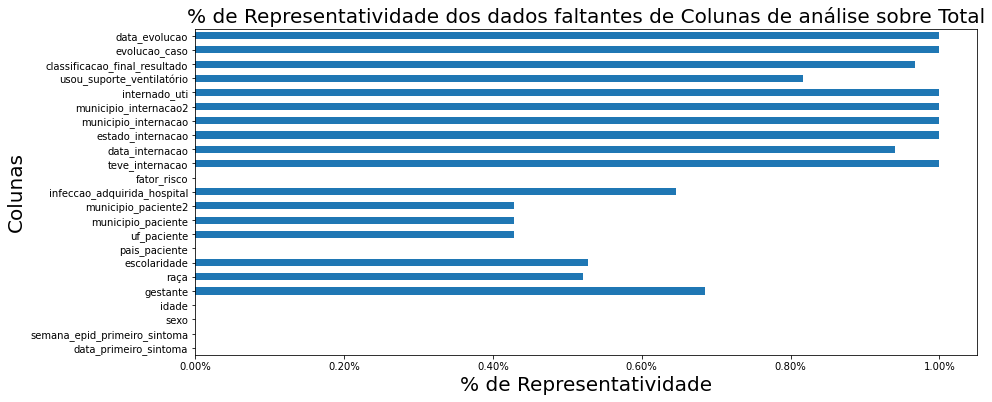

In [ ]:
dados_faltantes_total = pd.DataFrame(dados_srag.isna().sum(), columns= ['faltantes_total'])
dados_faltantes_total_sem_data_evolucao = pd.DataFrame(dados_srag[dados_srag.index.isin(index_de_dados_faltantes)].isna().sum(), columns= ['Colunas de análise'])
comparacao = pd.merge(dados_faltantes_total,dados_faltantes_total_sem_data_evolucao,left_index = True, right_index = True)[['faltantes_total','Colunas de análise']]

comparacao['%repres'] = comparacao['Colunas de análise']/comparacao['faltantes_total']
display(comparacao)
plt.figure(figsize=(14,6))
plt.title('% de Representatividade dos dados faltantes de Colunas de análise sobre Total', fontsize=20)
plt.xlabel('% de Representatividade', fontsize=20)
plt.ylabel('Colunas', fontsize=20)
grafico = comparacao['%repres'].plot(kind='barh')
grafico
grafico.xaxis.set_major_formatter(ticker.PercentFormatter())

## 2. Análise de Dados / Hipóteses

A análise consistirá nos seguintes pontos:

1) Os casos se comportam igual para mulheres e homens;

2) Os casos se comportam igual para mulher e mulheres gravidas;

3) Os casos se comportam igual para as raças;

4) Os casos se comportam igual entre  todas as escolaridades;

5) Pessoas com Fator de Risco possuem o mesmo comportamento;

6) Os dois grupos de Idades com mais casos se comportam igual.

### 2.1 Os casos se comportam igual para mulheres e homens

In [ ]:
dados_analise = dados_srag[dados_srag['evolucao_caso'].notnull()]
dados_analise = dados_analise[dados_analise['classificacao_final_resultado'] == 'SRAG por COVID-19']

In [ ]:
tamanho_amostra = len(dados_analise)
k = int(1 + ((10/3) *np.log10(tamanho_amostra)))
k

20

In [ ]:
dados_analise['classe_idade'] = pd.cut(x = dados_analise['idade'],
      bins = k,
      include_lowest = True)
dados_analise[['idade','classe_idade']]

,idade,classe_idade
11,57,"(51.15, 58.6]"
22,79,"(73.5, 80.95]"
26,72,"(66.05, 73.5]"
39,88,"(80.95, 88.4]"
49,54,"(51.15, 58.6]"
...,...,...
1153400,31,"(28.8, 36.25]"
1153402,63,"(58.6, 66.05]"
1153403,75,"(73.5, 80.95]"
1153405,79,"(73.5, 80.95]"


In [ ]:
dados_analise['classificacao_final_resultado'].value_counts()

SRAG por COVID-19    577804
Name: classificacao_final_resultado, dtype: int64

<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='Idade', ylabel='Count'>

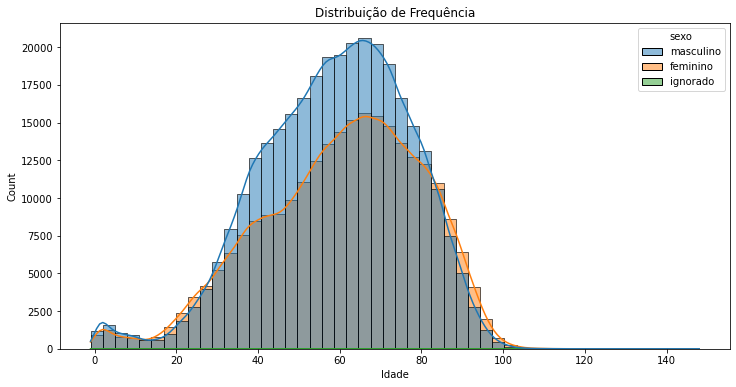

In [ ]:
ax = sns.histplot(data = dados_analise, x = 'idade',bins = 50, kde = True, hue = 'sexo')
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequência')
ax.set_xlabel('Idade')
ax

In [ ]:
distribuicao_masculino = dados_analise[dados_analise['sexo'] == 'masculino']['data_primeiro_sintoma']
distribuicao_feminino = dados_analise[dados_analise['sexo'] == 'feminino']['data_primeiro_sintoma']
_,p_value = ranksums(distribuicao_masculino,distribuicao_feminino)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


In [ ]:
### 2.2 Os casos se comportam igual para mulher e mulheres gravidas

In [ ]:
dados_analise_gestante = dados_analise[(dados_analise['sexo'] == 'feminino')&(dados_analise['gestante'] != 'Não se aplica')&(dados_analise['gestante'] != 'Ignorado')]

In [ ]:
dic_esta_gravida = {'Não': 'Não',
                   '3º Trimestre': 'Sim',
                   '2º Trimestre': 'Sim',
                   '1º Trimestre': 'Sim',
                   'Idade Gestacional Ignorada': 'Ignorado',
                   np.nan: 'nan'}

dados_analise_gestante['e_gestante'] = dados_analise_gestante['gestante'].map(lambda x: dic_esta_gravida[x])

<ipython-input-28-9bfbbb33a482>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_analise_gestante['e_gestante'] = dados_analise_gestante['gestante'].map(lambda x: dic_esta_gravida[x])


In [ ]:
frequencia_cruzada = pd.crosstab(dados_analise_gestante["classe_idade"], dados_analise_gestante["e_gestante"], normalize = 'columns') * 100
frequencia_cruzada

e_gestante,Ignorado,Não,Sim,nan
classe_idade,,,,
"(-1.15, 6.45]",0.000000,0.005532,0.000000,10.0
"(6.45, 13.9]",1.351351,0.263338,0.229568,80.0
"(13.9, 21.35]",15.202703,1.322778,15.587695,0.0
"(21.35, 28.8]",25.675676,3.142911,30.303030,10.0
"(28.8, 36.25]",27.027027,6.515966,36.983471,0.0
"(36.25, 43.7]",13.851351,8.513687,13.911846,0.0
"(43.7, 51.15]",9.797297,11.323552,1.997245,0.0
"(51.15, 58.6]",6.418919,12.621988,0.803489,0.0
"(58.6, 66.05]",0.675676,16.083560,0.183655,0.0


<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='Idade', ylabel='Count'>

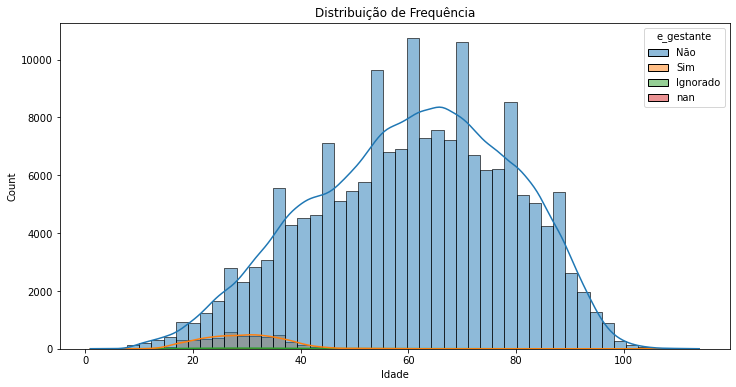

In [ ]:
ax = sns.histplot(data = dados_analise_gestante, x = 'idade',bins = 50, kde = True, hue = 'e_gestante')
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequência')
ax.set_xlabel('Idade')
ax

In [ ]:
distribuicao_gestante = dados_analise_gestante[dados_analise_gestante['e_gestante'] == 'Sim']['data_primeiro_sintoma']
distribuicao_nao_gestante = dados_analise_gestante[dados_analise_gestante['e_gestante'] == 'Não']['data_primeiro_sintoma']
_,p_value = ranksums(distribuicao_gestante,distribuicao_nao_gestante)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


In [ ]:
### 2.3 Os casos se comportam igual para as raças

In [ ]:
frequencia_cruzada = pd.crosstab(dados_analise["classe_idade"], dados_analise["raça"], normalize = 'columns') * 100
frequencia_cruzada

raça,Amarela,Branca,Ignorado,Indígena,Parda,Preta
classe_idade,,,,,,
"(-1.15, 6.45]",0.486275,0.708320,1.064402,5.872576,1.611849,0.586706
"(6.45, 13.9]",0.298039,0.393009,0.534738,2.714681,0.871788,0.423320
"(13.9, 21.35]",1.192157,0.802280,0.927420,4.099723,1.522129,0.984033
"(21.35, 28.8]",3.498039,2.325077,2.606719,4.598338,3.137090,2.677312
"(28.8, 36.25]",5.898039,5.802077,6.679655,6.648199,6.572383,6.312662
"(36.25, 43.7]",7.874510,8.105923,9.426400,6.869806,8.782712,8.852581
"(43.7, 51.15]",10.352941,11.016899,12.425801,11.080332,11.681240,12.209432
"(51.15, 58.6]",11.576471,12.524789,13.451645,10.914127,12.447231,13.026365
"(58.6, 66.05]",15.968627,16.430485,16.189259,12.188366,16.024624,17.415522


<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='Idade', ylabel='Count'>

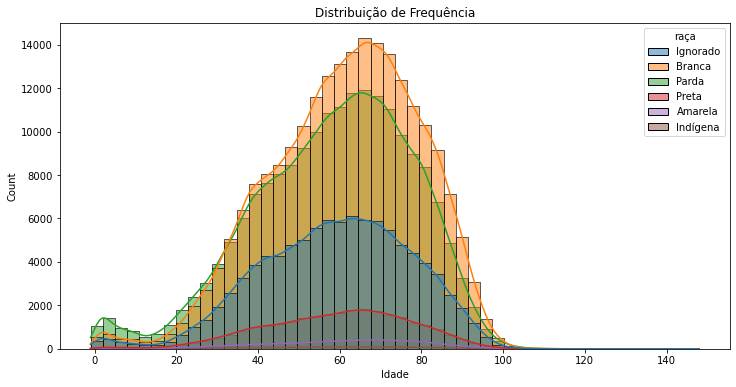

In [ ]:
ax = sns.histplot(data = dados_analise, x = 'idade',bins = 50, kde = True, hue = 'raça')
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequência')
ax.set_xlabel('Idade')
ax

In [ ]:
distribuicao_branco = dados_analise[dados_analise['raça'] == 'Branca']['data_primeiro_sintoma']
distribuicao_preta = dados_analise[dados_analise['raça'] == 'Preta']['data_primeiro_sintoma']
_,p_value = ranksums(distribuicao_branco,distribuicao_preta)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


In [ ]:
### 2.4 Os casos se comportam igual entre  todas as escolaridades

In [ ]:
frequencia_cruzada = pd.crosstab(dados_analise["classe_idade"], dados_analise["escolaridade"], normalize = 'columns') * 100
frequencia_cruzada

escolaridade,Médio (1º ao 3º ano),Fundamental 1º ciclo (1ª a 5ª série),Fundamental 2º ciclo (6ª a 9ª série),Ignorado,Não se aplica,Sem escolaridade/Analfabeto,Superior
classe_idade,,,,,,,
"(-1.15, 6.45]",0.018229,0.388178,0.023299,0.348756,82.549562,3.605816,0.006118
"(6.45, 13.9]",0.039496,1.157477,0.647182,0.379591,15.467958,0.743134,0.006118
"(13.9, 21.35]",2.406234,0.425232,1.812110,0.880928,1.498386,0.516963,0.446592
"(21.35, 28.8]",5.690501,0.737539,2.210774,2.272764,0.461042,0.542811,4.725927
"(28.8, 36.25]",11.581522,1.653286,4.664889,5.682175,0.023052,1.117932,13.275419
"(36.25, 43.7]",14.428291,3.260697,7.331280,8.227138,0.000000,1.815832,15.964150
"(43.7, 51.15]",16.365128,6.985443,12.418131,11.481842,0.000000,3.457189,16.325095
"(51.15, 58.6]",14.843002,10.786061,14.952497,12.797652,0.000000,5.357027,14.095191
"(58.6, 66.05]",13.936107,18.480812,19.609620,16.635566,0.000000,11.528271,14.486725


<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='Idade', ylabel='Count'>

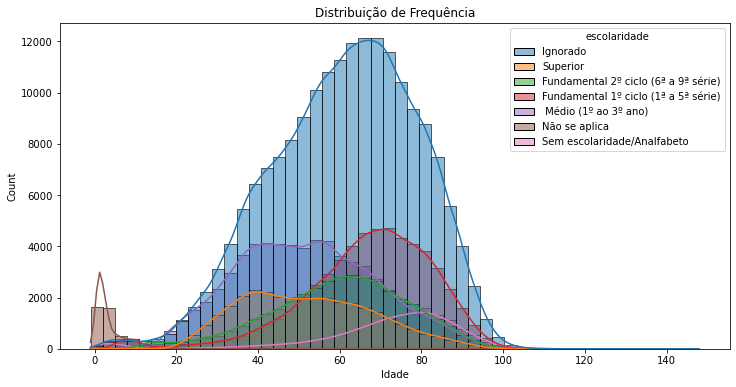

In [ ]:
ax = sns.histplot(data = dados_analise, x = 'idade',bins = 50, kde = True, hue = 'escolaridade')
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequência')
ax.set_xlabel('Idade')
ax

In [ ]:
distribuicao_ensino_medio = dados_analise[dados_analise['escolaridade'] == ' Médio (1º ao 3º ano)']['data_primeiro_sintoma']
distribuicao_superior = dados_analise[dados_analise['escolaridade'] == 'Superior']['data_primeiro_sintoma']
_,p_value = ranksums(distribuicao_ensino_medio,distribuicao_superior)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


In [ ]:
distribuicao_ensino_inicio_fundamental = dados_analise[dados_analise['escolaridade'] == 'Fundamental 1º ciclo (1ª a 5ª série)']['data_primeiro_sintoma']
distribuicao_analfabeto = dados_analise[dados_analise['escolaridade'] == 'Sem escolaridade/Analfabeto']['data_primeiro_sintoma']
_,p_value = ranksums(distribuicao_ensino_inicio_fundamental,distribuicao_analfabeto)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


In [ ]:
### 2.5 Pessoas com Fator de Risco possuem o mesmo comportamento.

In [ ]:
frequencia_cruzada = pd.crosstab(dados_analise["classe_idade"], dados_analise["fator_risco"], normalize = 'columns') * 100
frequencia_cruzada

fator_risco,Não,Sim
classe_idade,,
"(-1.15, 6.45]",2.051045,0.515614
"(6.45, 13.9]",1.048153,0.313119
"(13.9, 21.35]",1.914785,0.648255
"(21.35, 28.8]",4.919173,1.500906
"(28.8, 36.25]",11.102324,3.619354
"(36.25, 43.7]",13.735570,5.777756
"(43.7, 51.15]",15.243005,9.547146
"(51.15, 58.6]",12.972324,12.467146
"(58.6, 66.05]",12.690276,18.223157


<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='Idade', ylabel='Count'>

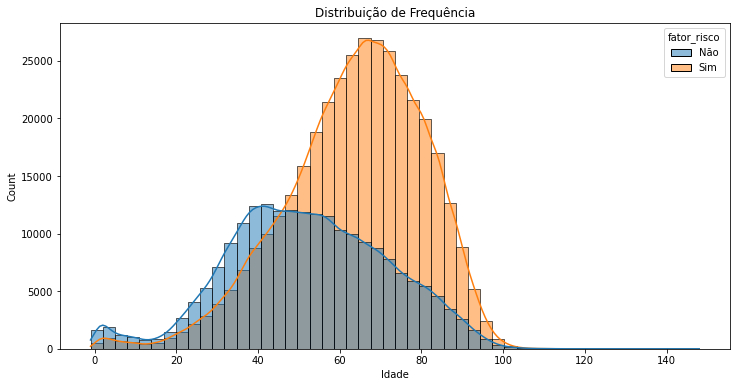

In [ ]:
ax = sns.histplot(data = dados_analise, x = 'idade',bins = 50, kde = True, hue = 'fator_risco')
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequência')
ax.set_xlabel('Idade')
ax

In [ ]:
distribuicao_tem_fator_risco = dados_analise[dados_analise['fator_risco'] == 'Sim']['data_primeiro_sintoma']
distribuicao_nao_tem_fator_risco = dados_analise[dados_analise['fator_risco'] == 'Não']['data_primeiro_sintoma']
_,p_value = ranksums(distribuicao_tem_fator_risco,distribuicao_nao_tem_fator_risco)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


In [ ]:
### 2.6 Os dois grupos de Idades com mais casos se comportam igual

In [ ]:
frequencia = dados_analise['classe_idade'].value_counts()
percentual = dados_analise['classe_idade'].value_counts(normalize = True) * 100
dist_freq = pd.DataFrame({'Frequência': frequencia, 'Percentual': percentual})
dist_freq

,Frequência,Percentual
"(58.6, 66.05]",93681,16.213283
"(66.05, 73.5]",81169,14.047843
"(51.15, 58.6]",73096,12.650657
"(43.7, 51.15]",67119,11.616223
"(73.5, 80.95]",67011,11.597531
"(80.95, 88.4]",53925,9.332750
"(36.25, 43.7]",50087,8.668510
"(28.8, 36.25]",36619,6.337616
"(88.4, 95.85]",19687,3.407211
"(21.35, 28.8]",15847,2.742626


In [ ]:
frequencia = dados_analise[dados_analise['classificacao_final_resultado'] == 'SRAG por COVID-19']['classe_idade'].value_counts()
percentual = dados_analise[dados_analise['classificacao_final_resultado'] == 'SRAG por COVID-19']['classe_idade'].value_counts(normalize = True) * 100
dist_freq = pd.DataFrame({'Frequência': frequencia, 'Percentual': percentual})
dist_freq

,Frequência,Percentual
"(58.6, 66.05]",93681,16.213283
"(66.05, 73.5]",81169,14.047843
"(51.15, 58.6]",73096,12.650657
"(43.7, 51.15]",67119,11.616223
"(73.5, 80.95]",67011,11.597531
"(80.95, 88.4]",53925,9.332750
"(36.25, 43.7]",50087,8.668510
"(28.8, 36.25]",36619,6.337616
"(88.4, 95.85]",19687,3.407211
"(21.35, 28.8]",15847,2.742626


In [ ]:
dados_analise_piores_classes = dados_analise[(dados_analise['classe_idade'] == dados_analise['classe_idade'].unique()[5])|(dados_analise['classe_idade'] == dados_analise['classe_idade'].unique()[7])]
dados_analise_piores_classes['classe_idade'].unique()

[(13.9, 21.35], (21.35, 28.8]]
Categories (2, interval[float64]): [(13.9, 21.35] < (21.35, 28.8]]

<AxesSubplot:title={'center':'Distribuição de Frequência'}, xlabel='Data do Primeiro Sintoma', ylabel='Count'>

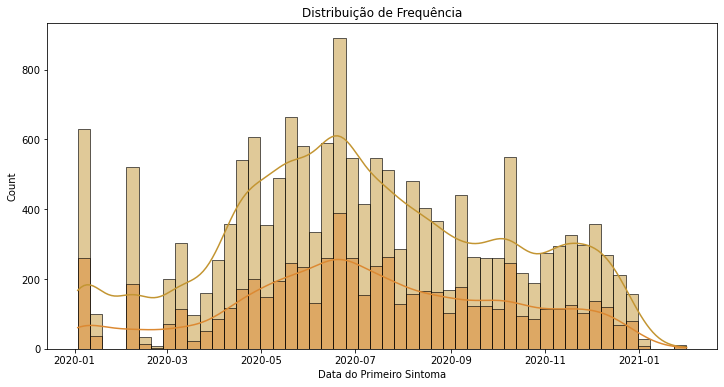

In [ ]:
ax = sns.histplot(data = dados_analise_piores_classes[dados_analise_piores_classes['classificacao_final_resultado'] 
                                                      == 'SRAG por COVID-19'], x = 'data_primeiro_sintoma',bins = 50, kde = True, hue = 'classe_idade')
ax.figure.set_size_inches(12,6)
ax.set_title('Distribuição de Frequência')
ax.set_xlabel('Data do Primeiro Sintoma')
ax.get_legend().remove()
ax

In [ ]:
distribuicao_idade_65_73 = dados_analise_piores_classes[dados_analise['classe_idade'] == dados_analise['classe_idade'].unique()[5]]['data_primeiro_sintoma']
distribuicao_idade_57_65 = dados_analise_piores_classes[dados_analise['classe_idade'] == dados_analise['classe_idade'].unique()[7]]['data_primeiro_sintoma']

<ipython-input-50-3bb01b44f4c3>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  distribuicao_idade_65_73 = dados_analise_piores_classes[dados_analise['classe_idade'] == dados_analise['classe_idade'].unique()[5]]['data_primeiro_sintoma']
<ipython-input-50-3bb01b44f4c3>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  distribuicao_idade_57_65 = dados_analise_piores_classes[dados_analise['classe_idade'] == dados_analise['classe_idade'].unique()[7]]['data_primeiro_sintoma']


In [ ]:
_,p_value = ranksums(distribuicao_idade_65_73,distribuicao_idade_57_65)
if p_value < 0.05:
    print("{:.2f}".format(p_value)+" - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição")
else:
    print("{:.2f}".format(p_value)+" - Aceitamos a hipótese nula que as duas distribuições provem da mesma distribuição")

0.00 - Rejeitamos a hipótese nula que as duas distribuições provem da mesma distribuição


## 3. Predição de Resultados

In [ ]:
dados_analise['casos'] = 1

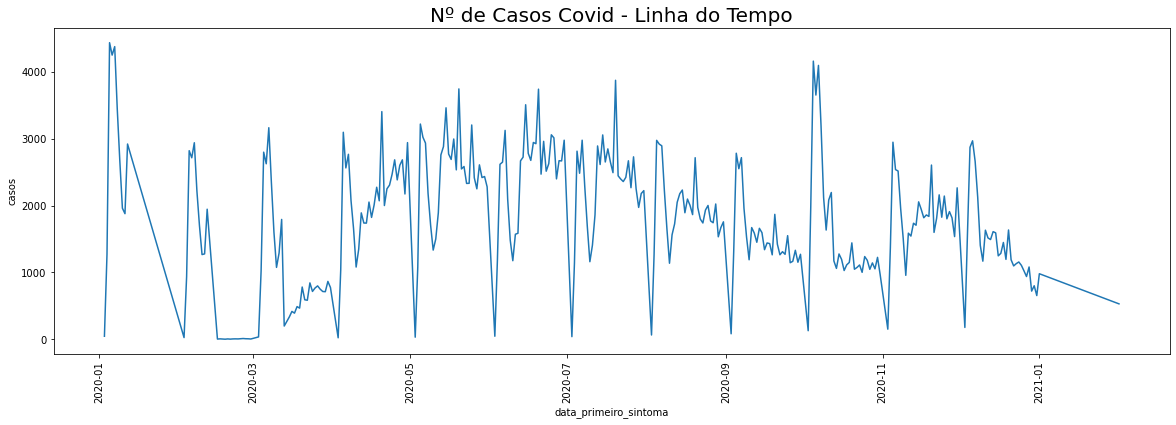

In [ ]:
data = pd.DataFrame(dados_analise.groupby('data_primeiro_sintoma')['casos'].sum()).reset_index()
plt.figure(figsize = (20,6))
plt.title('Nº de Casos Covid - Linha do Tempo', fontsize=20)
sns.lineplot(x='data_primeiro_sintoma', y='casos', data = data)
plt.xticks(rotation = 90)
plt.show()

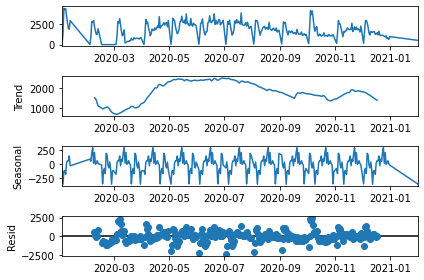

In [ ]:
decomposicao = seasonal_decompose(data.set_index('data_primeiro_sintoma'), period=30)
decomposicao.plot();

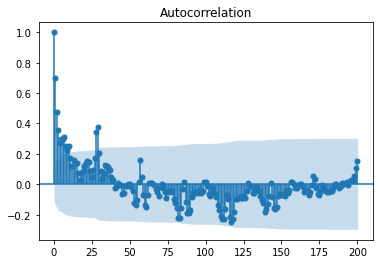

In [ ]:
plot_acf(data['casos'], lags=200);

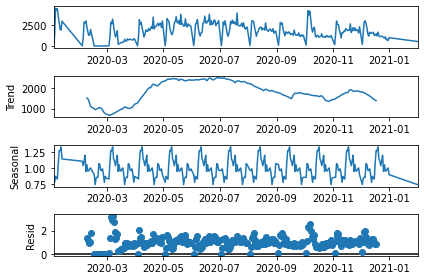

In [ ]:
decomposicao = seasonal_decompose(data.set_index('data_primeiro_sintoma'), period=30, model='multiplicative')
 
decomposicao.plot();

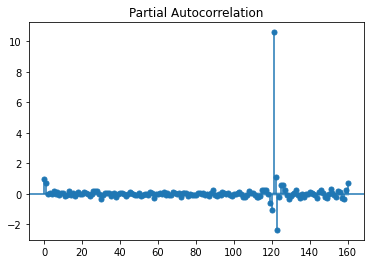

In [ ]:
plot_pacf(data['casos'], lags = 160);

In [ ]:
data['ano'] = data['data_primeiro_sintoma'].dt.year
data['mes'] = data['data_primeiro_sintoma'].dt.month

In [ ]:
dados_treino = data.query('mes <= 8 and ano == 2020')
dados_teste = data.query('mes > 8 and ano == 2020')

In [ ]:
dados_teste['mes'].unique()

array([ 9, 10, 11, 12], dtype=int64)

D:\anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
<ipython-input-65-67eee481adab>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

<AxesSubplot:xlabel='data_primeiro_sintoma', ylabel='casos'>

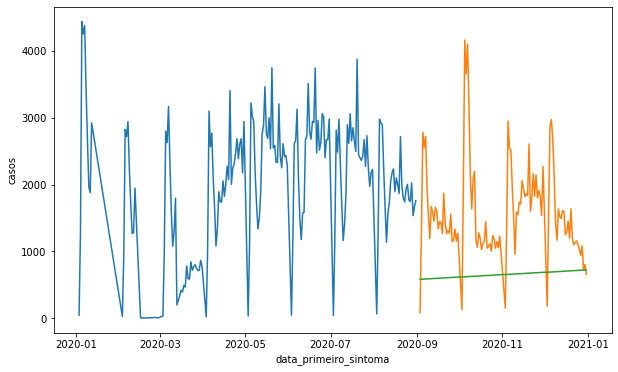

In [ ]:
modelo_arima = ARIMA(data['casos'].values.astype("float32"), order=[1,1,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(114)[0]
dados_teste['previsao'] = previsao
plt.figure(figsize = (10,6))
sns.lineplot(x= 'data_primeiro_sintoma',y = 'casos', data = dados_treino)
sns.lineplot(x= 'data_primeiro_sintoma',y = 'casos', data = dados_teste)
sns.lineplot(x= 'data_primeiro_sintoma',y = 'previsao', data = dados_teste)

In [ ]:
modelo_autoarima = auto_arima(dados_treino['casos'].values, error_action = 'ignore', trace = True, seasonal = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=3317.565, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=3315.305, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=3313.375, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3315.591, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=3313.784, Time=0.11 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=3315.322, Time=0.25 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=3315.259, Time=0.27 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=3313.526, Time=0.19 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=3316.545, Time=0.41 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=3316.303, Time=0.09 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=3297.287, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=3297.945, Time=0.17 sec
 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=3

<ipython-input-67-0b175f9aec8d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_teste['previsao_autoarima'] = previsao_autoarima


<AxesSubplot:xlabel='data_primeiro_sintoma', ylabel='casos'>

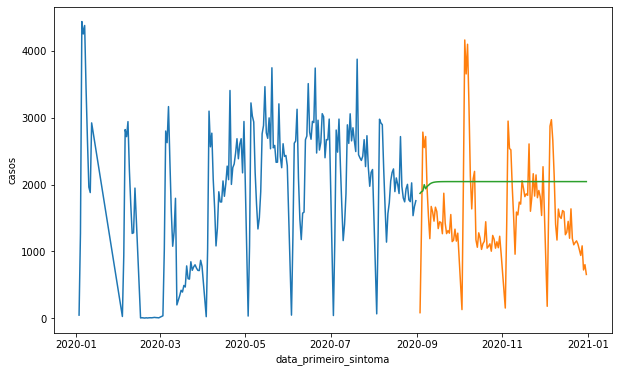

In [ ]:
previsao_autoarima = modelo_autoarima.predict(114)
dados_teste['previsao_autoarima'] = previsao_autoarima
plt.figure(figsize = (10,6))
sns.lineplot(x= 'data_primeiro_sintoma',y = 'casos', data = dados_treino)
sns.lineplot(x= 'data_primeiro_sintoma',y = 'casos', data = dados_teste)
sns.lineplot(x= 'data_primeiro_sintoma',y = 'previsao_autoarima', data = dados_teste)